# Google Colab: Access Webcam for Images and Video
This notebook will go through how to access and run code on images and video taken using your webcam.  

For this purpose of this tutorial we will be using OpenCV's Haar Cascade to do face detection on our Webcam image and video.

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

## Helper Functions
Below are a few helper function to make converting between different image data types and formats. 

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

## Haar Cascade Classifier
For this tutorial we will run a simple object detection algorithm called Haar Cascade on our images and video fetched from our webcam. OpenCV has a pre-trained Haar Cascade face detection model. 

In [ ]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

## Webcam Images
Running code on images taken from webcam is fairly straight-forward. We will utilize code within Google Colab's **Code Snippets** that has a variety of useful code functions to perform various tasks.

We will be using the code snippet for **Camera Capture** to utilize your computer's webcam.

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


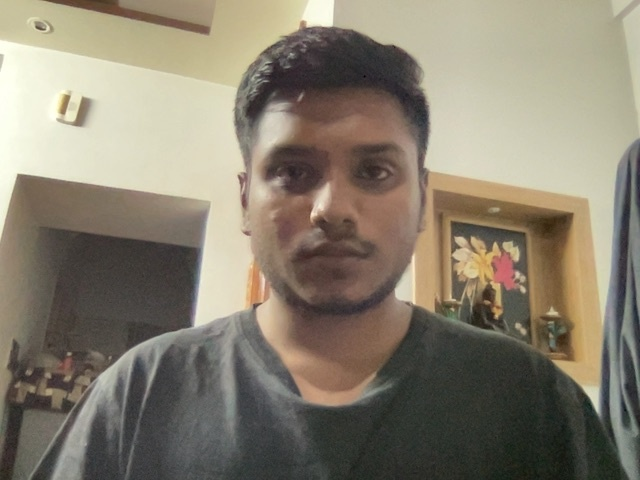

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## Webcam Videos
Running code on webcam video is a little more complex than images. We need to start a video stream using our webcam as input. Then we run each frame through our progam (face detection) and create an overlay image that contains bounding box of detection(s). We then overlay the bounding box image back onto the next frame of our video stream.

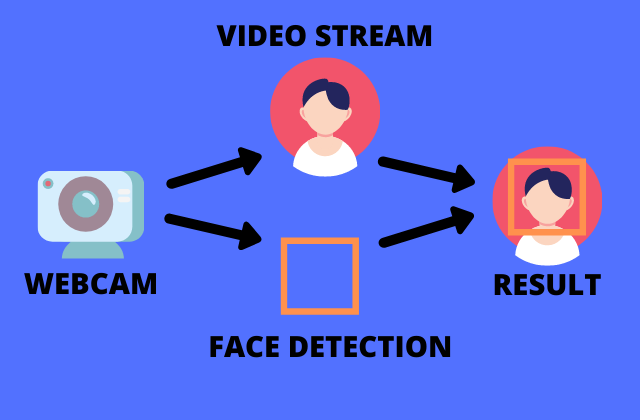</center>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Hope You Enjoyed!
If you enjoyed the tutorial and want to see more videos or tutorials check out my YouTube channel [HERE](https://www.youtube.com/channel/UCrydcKaojc44XnuXrfhlV8Q?sub_confirmation=1)

Have a great day!

In [ ]:
!pip install face_recognition

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100.1 MB 22 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566186 sha256=de8d086255436cae9b2e9c3e392f6126fa31378a866d722ece1d20b21a4b18af
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [ ]:
import face_recognition
from google.colab.patches import cv2_imshow
import pickle
import cv2
import os
from imutils import paths

imagePath = list(paths.list_images('/content/drive/MyDrive/OuR_Dataset'))
print(imagePath)
print("\n")
kEncodings = []
kNames = []

# loop over the image paths
for (i, ip) in enumerate(imagePath):
    # extract the person name from the image path
    name = ip.split(os.path.sep)[-2]
    # load the input image and convert it from BGR
    image = cv2.imread(ip)
    #image = cv2.resize(image, (0, 0), fx = 0.1, fy = 0.1)
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    boxes = face_recognition.face_locations(rgb, model='cnn')
    # compute the facial embedding for the any face
    encodings = face_recognition.face_encodings(rgb, boxes)
# loop over the encodings
    for encoding in encodings:
        kEncodings.append(encoding)
        kNames.append(name)

data = {"encodings": kEncodings, "names": kNames}
# use pickle to save data into a file for later use
f = open("face_enc", "wb")
f.write(pickle.dumps(data))  # to open file in write mode
f.close()  # to close file

# to find path of xml file containing haarCascade file

cfp = os.path.dirname(cv2.__file__) + "/data/haarcascade_frontalface_alt2.xml"

fc = cv2.CascadeClassifier(cfp)


# load the known faces and embeddings saved in last file
data = pickle.loads(open('/content/face_enc' ,"rb").read())



['/content/drive/MyDrive/OuR_Dataset/Kaushik/k0.jpg', '/content/drive/MyDrive/OuR_Dataset/Kaushik/k2.jpg', '/content/drive/MyDrive/OuR_Dataset/Kaushik/k3.jpg', '/content/drive/MyDrive/OuR_Dataset/Kaushik/k4.jpg', '/content/drive/MyDrive/OuR_Dataset/Kaushik/k5.jpg', '/content/drive/MyDrive/OuR_Dataset/Ishaan Joshi/Photo on 10-04-22 at 5.37 PM #2.jpg', '/content/drive/MyDrive/OuR_Dataset/Ishaan Joshi/Photo on 10-04-22 at 5.37 PM #3.jpg', '/content/drive/MyDrive/OuR_Dataset/Ishaan Joshi/Photo on 10-04-22 at 5.37 PM #4.jpg', '/content/drive/MyDrive/OuR_Dataset/Ishaan Joshi/Photo on 10-04-22 at 5.37 PM #5.jpg', '/content/drive/MyDrive/OuR_Dataset/Ishaan Joshi/Photo on 10-04-22 at 5.38 PM.jpg', '/content/drive/MyDrive/OuR_Dataset/Ishaan Joshi/Photo on 10-04-22 at 5.37 PM.jpg']




In [ ]:
import math

def face_distance_to_conf(face_distance, face_match_threshold=0.6):
    if face_distance > face_match_threshold:
        range = (1.0 - face_match_threshold)
        linear_val = (1.0 - face_distance) / (range * 2.0)
        return linear_val
    else:
        range = face_match_threshold
        linear_val = 1.0 - (face_distance / (range * 2.0))
        return (linear_val + ((1.0 - linear_val) *  math.pow((linear_val - 0.5) * 2, 0.2))) * 100

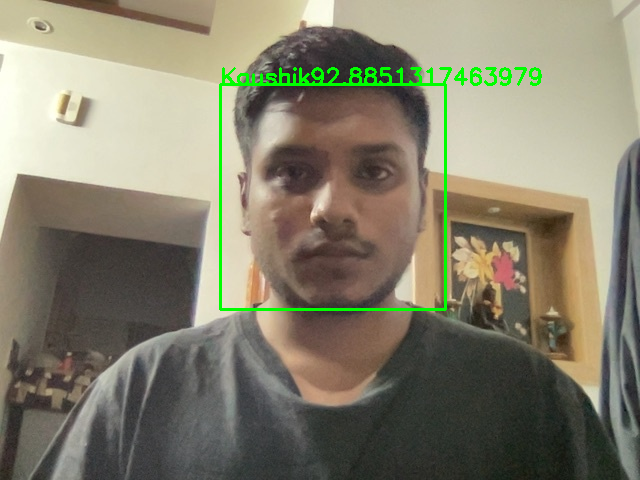

-1

In [ ]:
import math


# Find path to the image you want to detect face and pass it here
image = cv2.imread('/content/photo.jpg')
#image = cv2.resize(image, (0, 0), fx = 0.1, fy = 0.1)
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# convert image to Greyscale for HaarCascade
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
faces = fc.detectMultiScale(gray,
                            scaleFactor=1.1,
                            minNeighbors=6,
                            minSize=(60, 60),
                            flags=cv2.CASCADE_SCALE_IMAGE)
# the facial embeddings for face in input
encodings = face_recognition.face_encodings(rgb)
names = []


for encoding in encodings:
    # Compare encodings with encodings in data["encodings"]
    # Matches contain array with boolean values True and False
    matches = face_recognition.compare_faces(data["encodings"],
                                             encoding)
    face_distances = face_recognition.face_distance(data["encodings"],
                                             encoding)
    distance = min(face_distances)
    # set name =unknown if no encoding matches
    name = "Unknown"
    # check to see if we have found a match
    if True in matches:
        # Find positions at which we get True and store them
        matchedIdxs = [i for (i, b) in enumerate(matches) if b]
        count = {}
        # loop over the matched indexes and maintain a count for
        # each recognized face face
        for i in matchedIdxs:
            # Check the names at respective indexes we stored in matchedIdxs
            name = data["names"][i]
            # increase count for the name we got
            count[name] = count.get(name, 0) + 1
        # set name which has highest count
        name = max(count, key=count.get)
    # will update the list of names
    names.append(name)
# do loop over the recognized faces

for ((x, y, w, h), name) in zip(faces, names):
    # rescale the face coordinates
    # draw the predicted face name on the image
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(image, str(name)+ str(face_distance_to_conf(distance)), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 2)
cv2_imshow(image)
cv2.waitKey(0)

